# Deep Learning

## Weather Classification

### Importing Libraries

In [63]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, auc
from sklearn.preprocessing import label_binarize

Data pre proccesing

In [64]:
dataset_dir = "big dataset"
total_files = len(os.listdir(dataset_dir))
print(f'Total files in dataset: {total_files}')

Total files in dataset: 11


In [65]:
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    files = os.listdir(folder_path)
    print(f'Number of images in {folder}: {len(files)}')
    print(f"First 5 files in {folder}: {files[:5]}")

Number of images in dew: 698
First 5 files in dew: ['2208.jpg', '2209.jpg', '2210.jpg', '2211.jpg', '2212.jpg']
Number of images in fogsmog: 851
First 5 files in fogsmog: ['4075.jpg', '4076.jpg', '4077.jpg', '4078.jpg', '4079.jpg']
Number of images in frost: 475
First 5 files in frost: ['3600.jpg', '3601.jpg', '3602.jpg', '3603.jpg', '3604.jpg']
Number of images in glaze: 639
First 5 files in glaze: ['6090.jpg', '6091.jpg', '6092.jpg', '6093.jpg', '6094.jpg']
Number of images in hail: 591
First 5 files in hail: ['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']
Number of images in lightning: 377
First 5 files in lightning: ['1830.jpg', '1831.jpg', '1832.jpg', '1833.jpg', '1834.jpg']
Number of images in rain: 526
First 5 files in rain: ['1011.jpg', '1013.jpg', '1017.jpg', '102.jpg', '1021.jpg']
Number of images in rainbow: 232
First 5 files in rainbow: ['0592.jpg', '0593.jpg', '0594.jpg', '0595.jpg', '0596.jpg']
Number of images in rime: 1160
First 5 files in rime: ['4930.jpg'

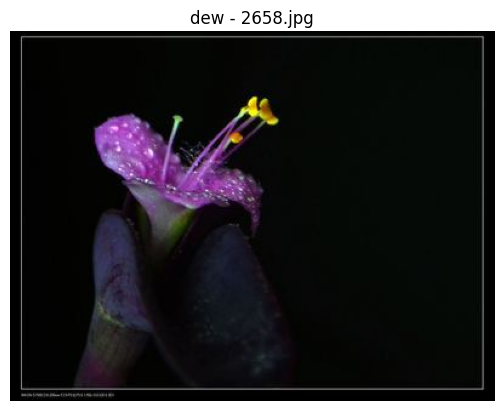

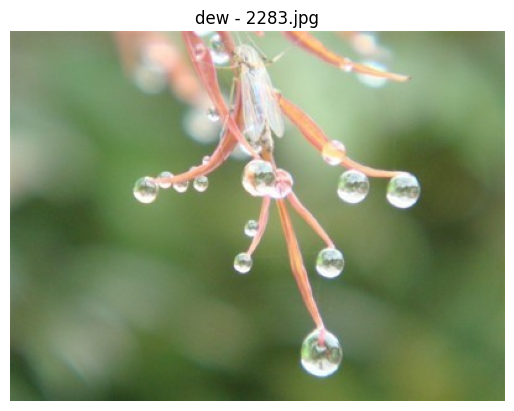

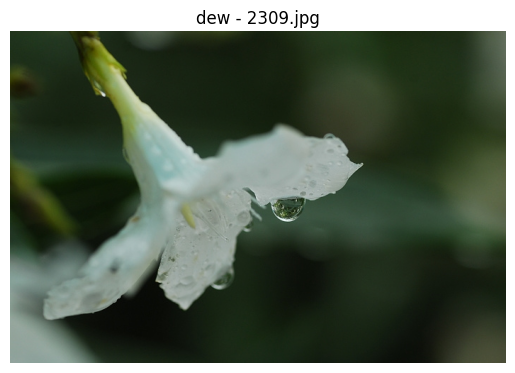

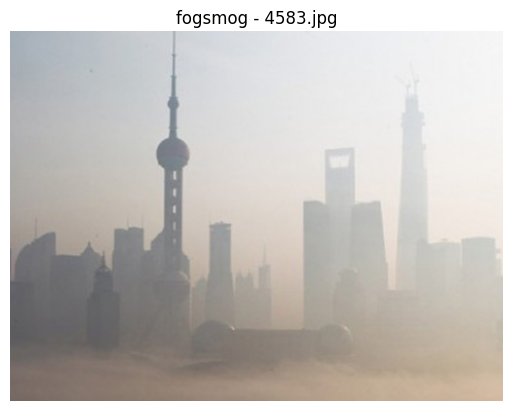

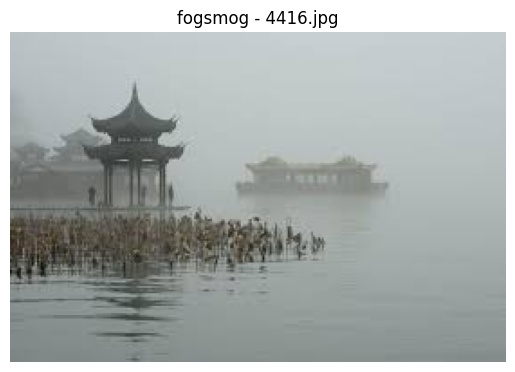

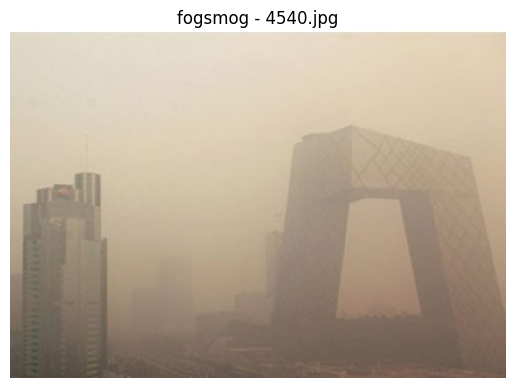

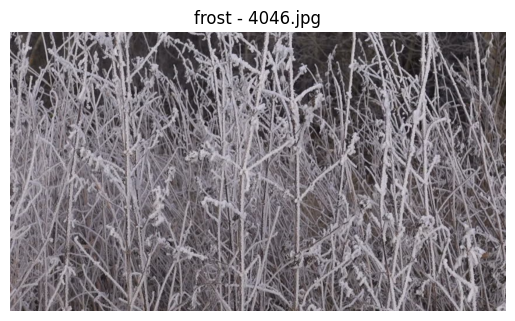

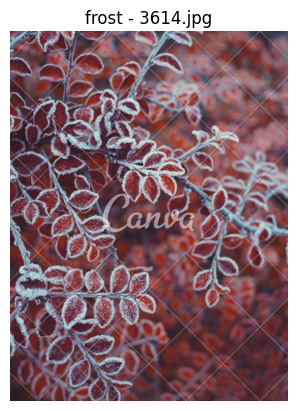

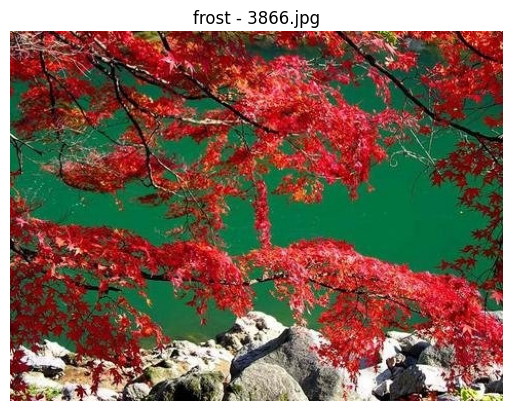

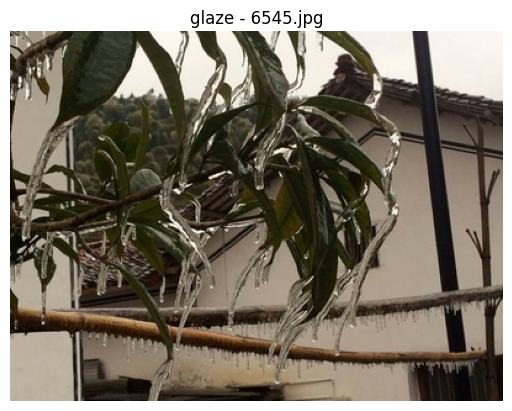

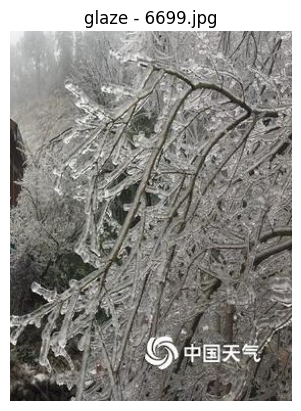

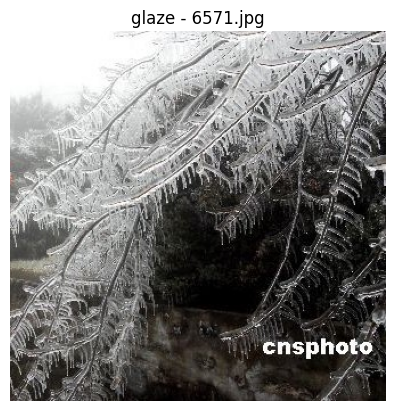

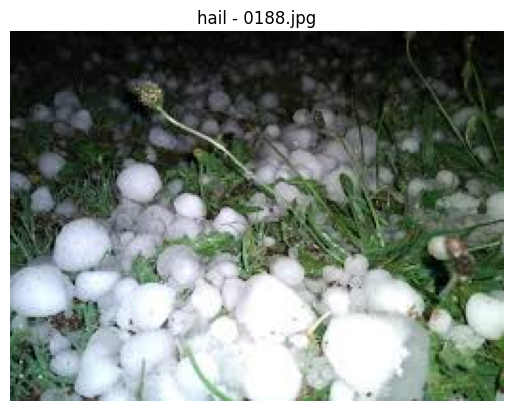

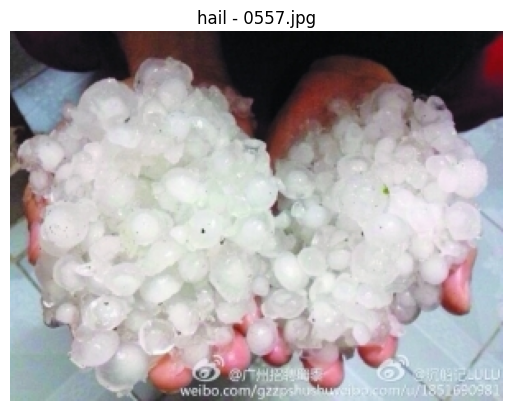

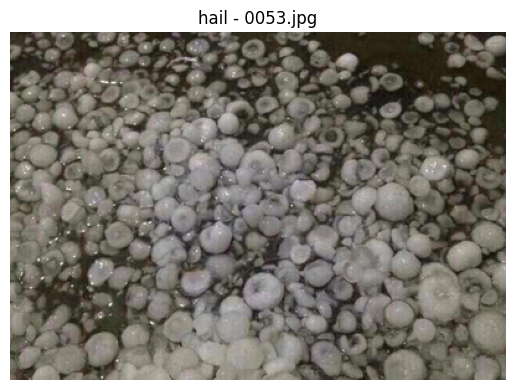

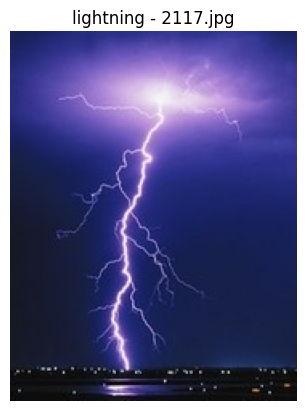

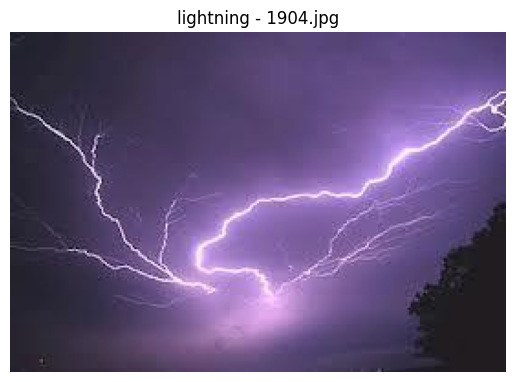

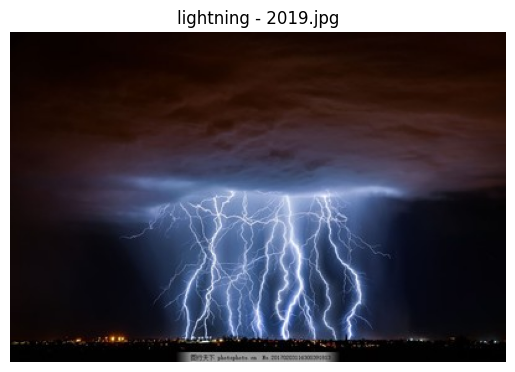

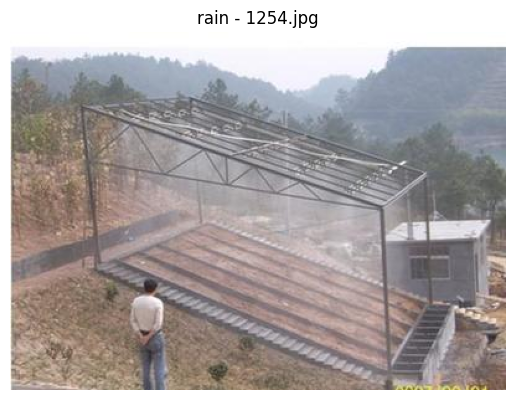

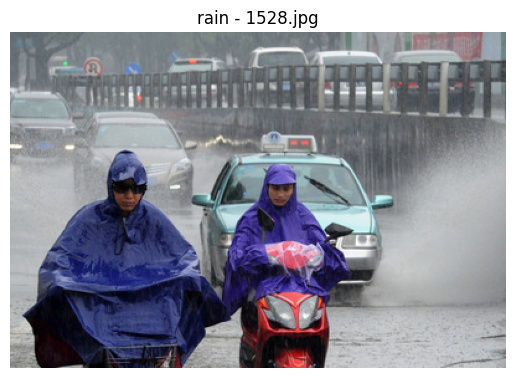

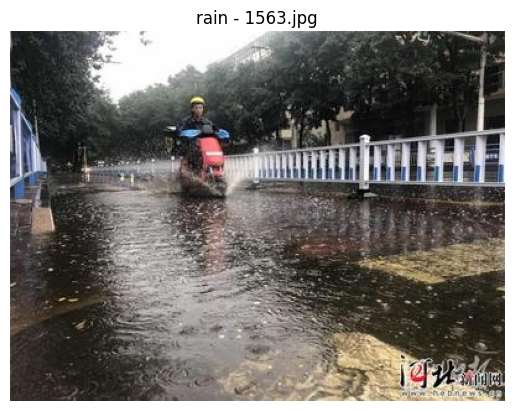

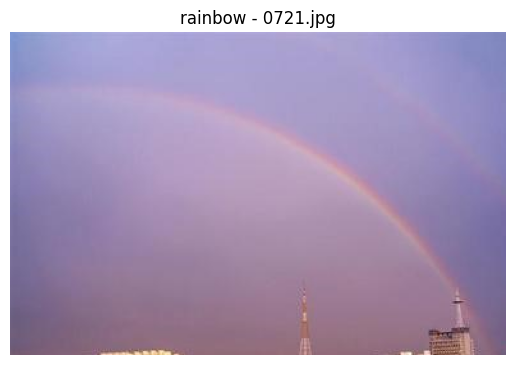

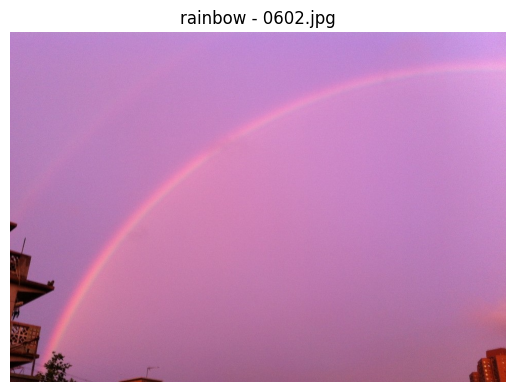

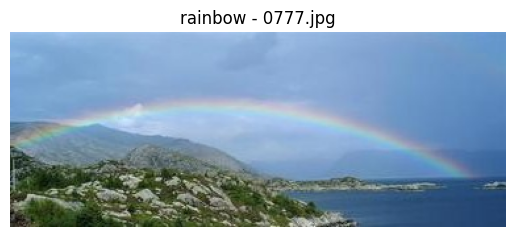

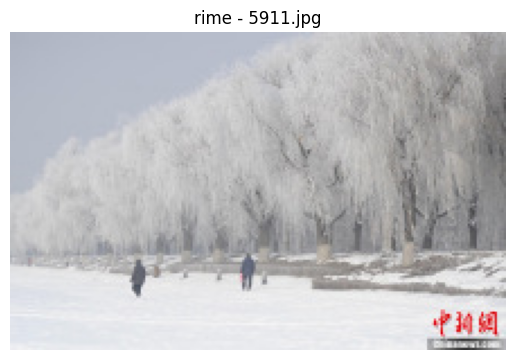

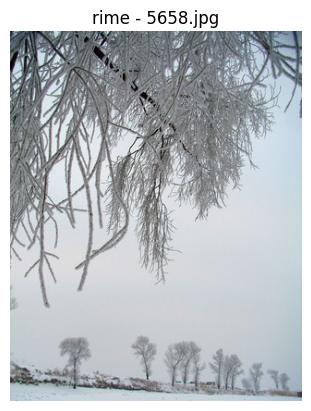

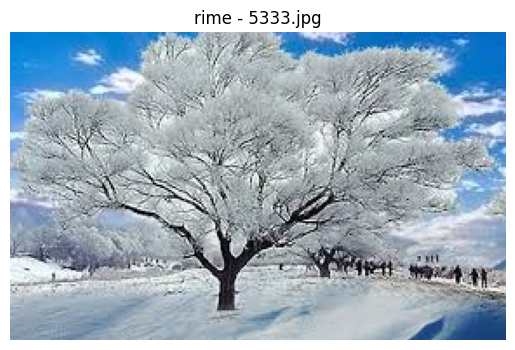

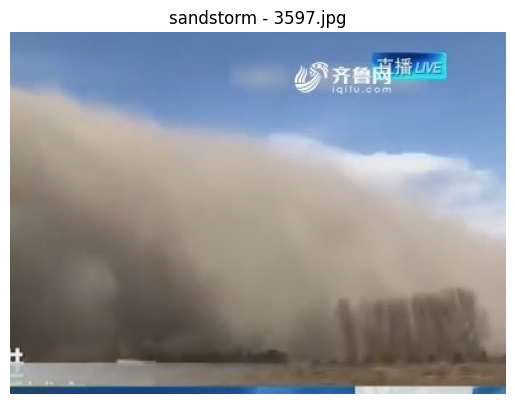

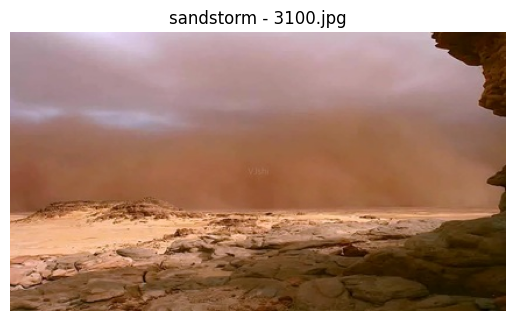

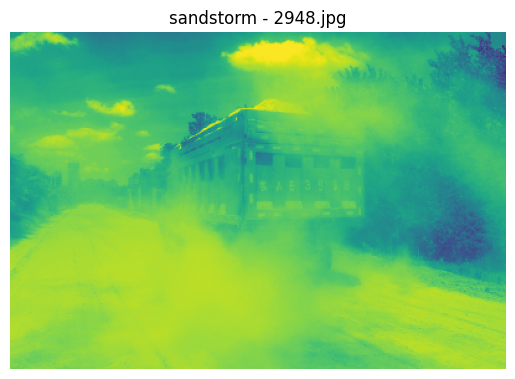

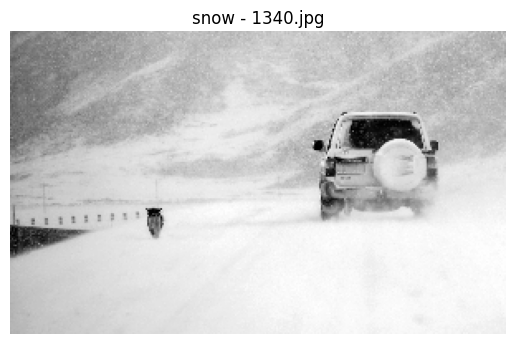

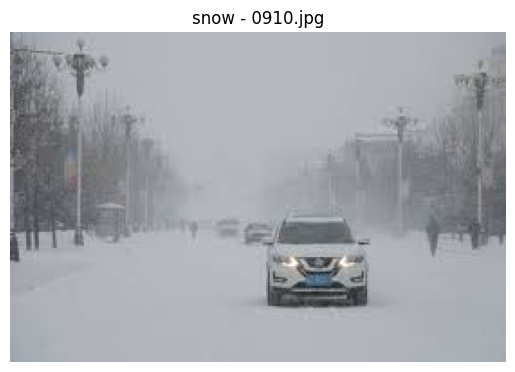

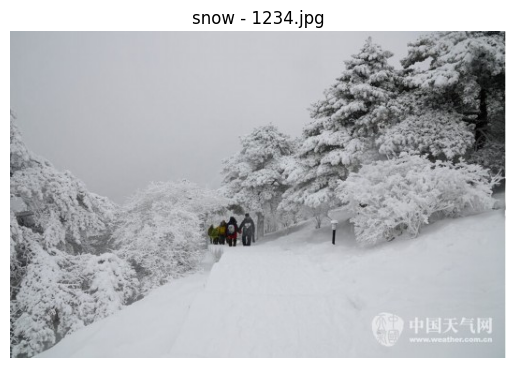

In [81]:
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    files = os.listdir(folder_path)
    sample_files = random.sample(files, k=3)
    for fname in sample_files:
            img_path = os.path.join(folder_path, fname)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{folder} - {fname}')
            plt.show()

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50pre 

flip_layer = RandomFlip("horizontal")
rotation_layer = RandomRotation(factor=15/360, fill_mode="reflect") 
translation_layer = RandomTranslation(height_factor=0.12, width_factor=0.12, fill_mode="reflect")
zoom_layer = RandomZoom(height_factor=0.10, width_factor=0.10, fill_mode="reflect")
def augment_and_preprocess(image, label,pre):
    image = flip_layer(image)
    image = rotation_layer(image)
    image = translation_layer(image)
    image = zoom_layer(image)
    image = pre(image)
    return image, label

def preprocess_only(image, label,pre):
    return pre(image), label

dataset_dir = "big dataset"
train_dataset = tf.keras.utils.image_dataset_from_directory(
dataset_dir, validation_split = .2, subset = 'training', seed=42, 
    image_size=(150, 150), batch_size=32, label_mode='int'
)
Validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split = .2, subset = 'validation', seed=42, 
    image_size=(150, 150), batch_size=32, label_mode='int'
)
val_test_batches = tf.data.experimental.cardinality(Validation_dataset)
test_batches = val_test_batches // 2
validation_batches = val_test_batches - test_batches
test_dataset = Validation_dataset.take(test_batches)
validation_dataset = Validation_dataset.skip(test_batches)
    
    
def get_data(pre):
    def augment_map(image, label):
        return augment_and_preprocess(image, label, pre)
        
    def preprocess_map(image, label):
        return preprocess_only(image, label, pre)
    train_dataset_final = (train_dataset
                           .map(augment_map, num_parallel_calls=tf.data.AUTOTUNE)
                           .cache()
                           .shuffle(1000)
                           .prefetch(tf.data.AUTOTUNE)
                          )
    
    validation_dataset_final = (validation_dataset
                                .map(preprocess_map, num_parallel_calls=tf.data.AUTOTUNE)
                                .cache()
                                .prefetch(tf.data.AUTOTUNE)
                               )
    test_dataset_final = (test_dataset
                                .map(preprocess_map, num_parallel_calls=tf.data.AUTOTUNE)
                                .cache()
                                .prefetch(tf.data.AUTOTUNE)
                               )
    return train_dataset_final, validation_dataset_final, test_dataset_final

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [68]:
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
class_names = train_dataset.class_names

Batch shape: (32, 150, 150, 3)


In [69]:
class_names = train_dataset.class_names
print("Classes:", class_names)

Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


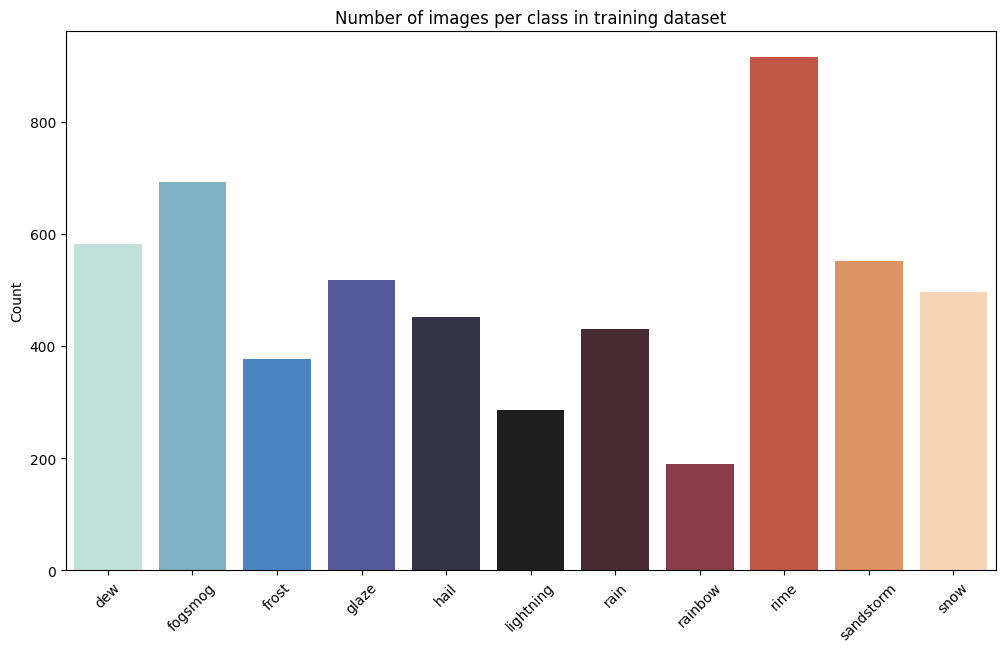

In [70]:
all_labels = []
class_names = train_dataset.class_names

for _, labels in train_dataset:
    all_labels.extend(labels.numpy())  


plt.figure(figsize=(12,7))
sns.countplot(x=all_labels, hue=all_labels, palette="icefire", legend=False)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title("Number of images per class in training dataset")
plt.ylabel("Count")
plt.show()

Helper functions

In [71]:
def Plot_Training_Loss_Curves(history):
    #plt.plot(history['train_loss'],label='Training loss')
    #plt.plot(history['val_loss'],label='Validation loss')
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def Plot_Training_Accuracy_Curves(history):
    #plt.plot(history['train_acc'],label='Training Accuracy')
    #plt.plot(history['val_acc'],label='Validation Accuracy')
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoches')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [72]:
def Calculate_Confusion_Matrix(y_true,y_pred,average='macro'):
    accuracy=np.mean( y_true == y_pred )
    precision=precision_score(y_true,y_pred,average=average,zero_division=0)
    recall=recall_score(y_true,y_pred,average=average,zero_division=0)
    f1=f1_score(y_true,y_pred,average=average,zero_division=0)
    return accuracy, precision, recall, f1

In [73]:
def Plot_Confuision_Matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def Plot_Roc_Auc_Curve(y_true,y_score,class_names):
    y_true_bin=label_binarize(y_true,classes=range(len(class_names)))
    plt.figure(figsize=(8,6))     
    for i, class_name in enumerate(class_names):
      fpr ,tpr , _ =roc_curve(y_true_bin[ :,i],y_score[:,i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr,tpr ,label=f"{class_name}(Auc={roc_auc:.2f})")
     
    plt.plot([0,1],[0,1],'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Resnet 50 pre-trained model with transfer learning

In [74]:
from tensorflow.keras.applications.resnet50 import preprocess_input as  resnet50pre
from tensorflow.keras.regularizers import l2
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3),
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
    name="resnet50",
)
for layer in pretrained_model.layers[:-30]:
    layer.trainable = False
for layer in pretrained_model.layers[-30:]:
    layer.trainable = True
resnet_model.add(pretrained_model)
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(11,activation='softmax',kernel_regularizer=l2(0.001)))
my_callbacks  = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [75]:
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,642,443 (94.00 MB)

 Trainable params: 15,504,907 (59.15 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [76]:
resnet_model.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.2965 - loss: 2.2376 - val_accuracy: 0.6657 - val_loss: 1.1364
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.6333 - loss: 1.1693 - val_accuracy: 0.7800 - val_loss: 0.7260
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.7778 - loss: 0.7475 - val_accuracy: 0.8143 - val_loss: 0.5977
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8342 - loss: 0.5610 - val_accuracy: 0.8443 - val_loss: 0.5272
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8825 - loss: 0.4221 - val_accuracy: 0.8500 - val_loss: 0.4960
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9148 - loss: 0.3217 - val_accuracy: 0.8600 - val_loss: 0.4699
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.9435 - loss: 0.2471 - val_accuracy: 0.8614 - val_loss: 0.4666
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.9556 - loss: 0.1951 - val_accu

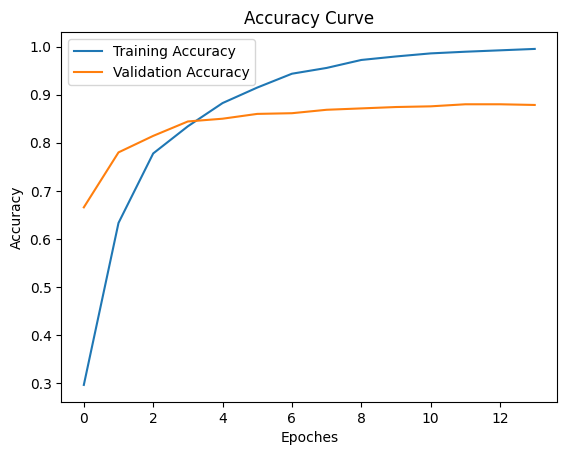

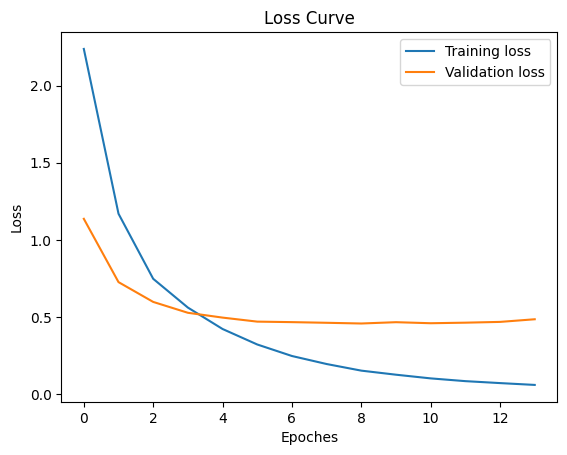

In [77]:
train,val,test = get_data(resnet50pre)
epochs=50
history = resnet_model.fit(
    train, 
    validation_data = val,
    epochs = epochs,
    callbacks=my_callbacks
)
Plot_Training_Accuracy_Curves(history)
Plot_Training_Loss_Curves(history)

In [78]:
y_score = resnet_model.predict(test)
y_pred = np.argmax(y_score, axis=1)
y_true_list = []
for images, labels in test:
    y_true_list.append(labels.numpy())
y_true = np.concatenate(y_true_list, axis=0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 814ms/step


In [79]:
accuracy, precision, recall, f1 = Calculate_Confusion_Matrix(y_true,y_pred)
print ("accuracy =", accuracy) 
print ("precision =", precision) 
print ("recall =", recall)
print ("f1 =" ,f1)

accuracy = 0.8407738095238095
precision = 0.8557024736923965
recall = 0.8326001967828606
f1 = 0.8418609532422617


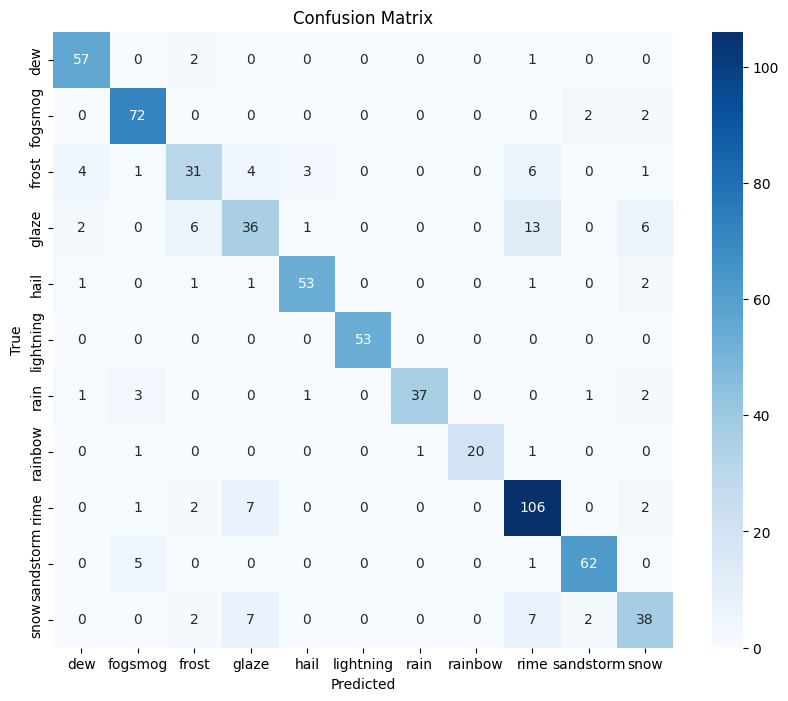

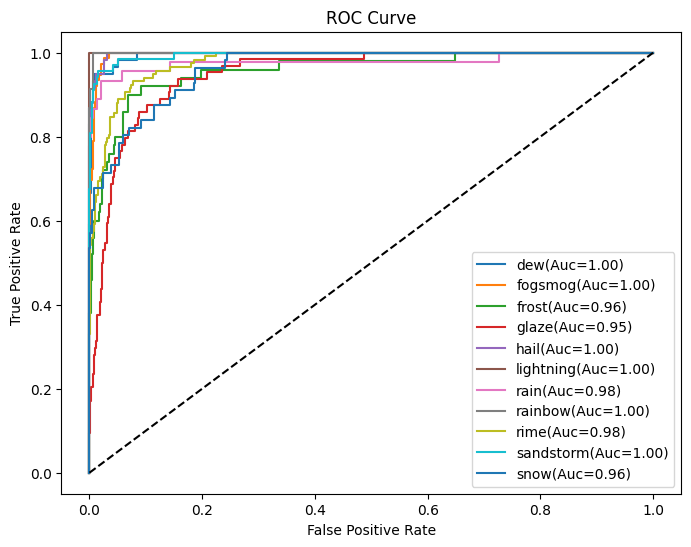

In [80]:
class_names = train_dataset.class_names
Plot_Confuision_Matrix(y_true, y_pred, class_names)
Plot_Roc_Auc_Curve(y_true, y_score, class_names)

mobile net

C:\Users\maria\AppData\Local\Temp\ipykernel_34668\797623158.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNet(


Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 85s 401ms/step - accuracy: 0.2002 - loss: 2.7496 - val_accuracy: 0.4829 - val_loss: 1.6608
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 68s 370ms/step - accuracy: 0.4246 - loss: 1.7929 - val_accuracy: 0.6386 - val_loss: 1.1746
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 66s 383ms/step - accuracy: 0.5561 - loss: 1.3426 - val_accuracy: 0.7071 - val_loss: 0.9394
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 51s 295ms/step - accuracy: 0.6479 - loss: 1.0603 - val_accuracy: 0.7443 - val_loss: 0.8131
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7075 - loss: 0.9027 - val_accuracy: 0.7700 - val_loss: 0.7249
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 45s 260ms/step - accuracy: 0.7441 - loss: 0.7783 - val_accuracy: 0.7829 - val_loss: 0.6749
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - accuracy: 0.7752 - loss: 0.6921 - val_accuracy: 0.7971 - val_loss: 0.6329
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 79s 275ms/step - accuracy: 0.8067 - loss: 0

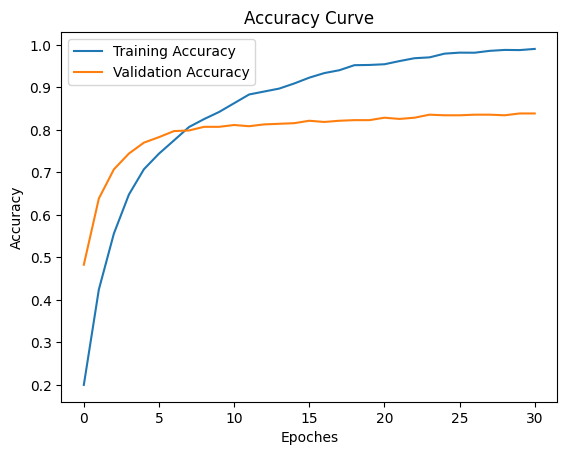

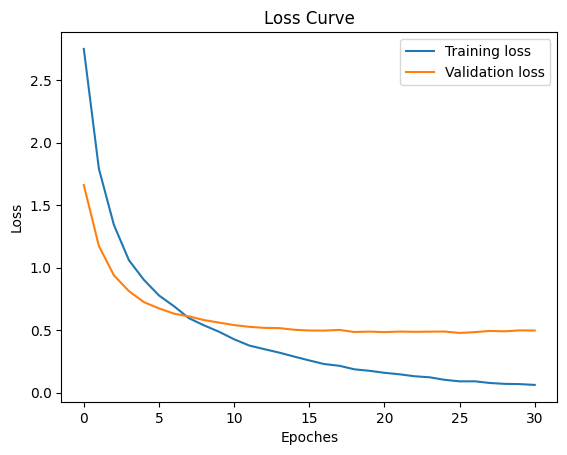

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as MobileNet_pre
mobileNet_model = Sequential()
pretrained_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3),
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
    name="mobilenet",
)
for layer in pretrained_model.layers[:-30]:
    layer.trainable = False
for layer in pretrained_model.layers[-30:]:
    layer.trainable = True
mobileNet_model.add(pretrained_model)
mobileNet_model.add(Dense(512,activation='relu'))
mobileNet_model.add(Dropout(0.5))
mobileNet_model.add(Dense(11,activation='softmax'))
my_callbacks  = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
mobileNet_model.compile(optimizer=Adam(learning_rate=0.00001),loss='crossentropy',metrics=['accuracy'])
train,val,test = get_data(MobileNet_pre)
history = mobileNet_model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)
Plot_Training_Accuracy_Curves(history)
Plot_Training_Loss_Curves(history)

In [ ]:
y_score = mobileNet_model.predict(test)
y_pred = np.argmax(y_score, axis=1)
y_true_list = []
for images, labels in test:
    y_true_list.append(labels.numpy())
y_true = np.concatenate(y_true_list, axis=0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step


In [ ]:
accuracy, precision, recall, f1 = Calculate_Confusion_Matrix(y_true,y_pred)
print ("accuracy =", accuracy) 
print ("precision =", precision) 
print ("recall =", recall)
print ("f1 =" ,f1)

accuracy = 0.8273809523809523
precision = 0.8419127693052574
recall = 0.8295217813591134
f1 = 0.8322518010639833


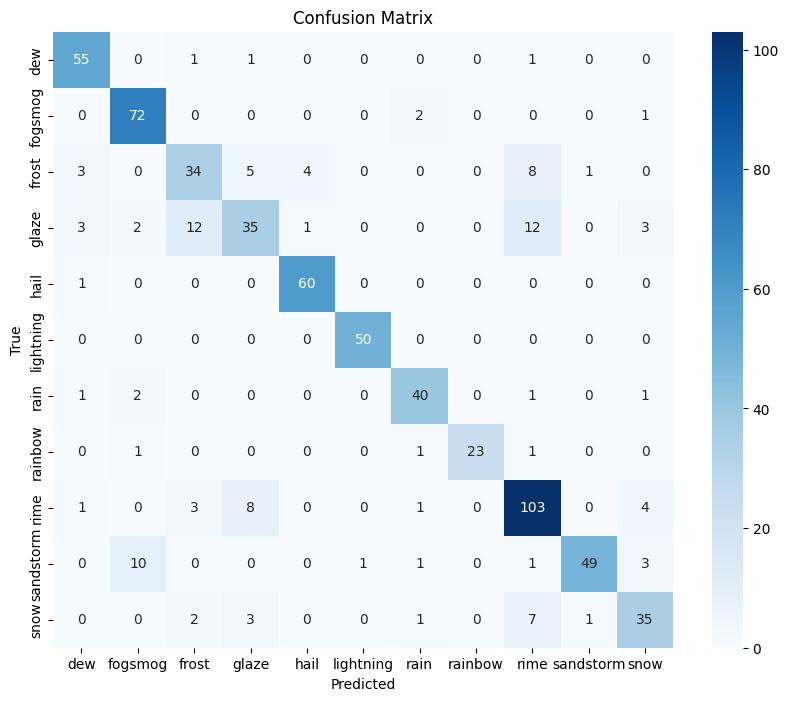

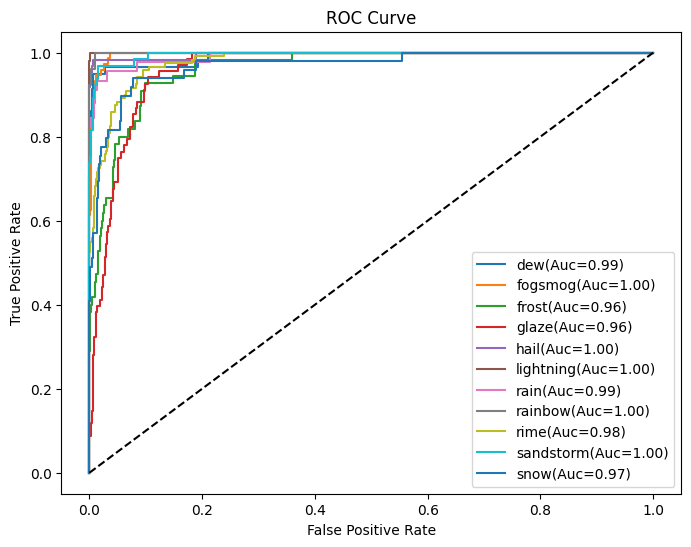

In [ ]:
class_names = train_dataset.class_names
Plot_Confuision_Matrix(y_true, y_pred, class_names)
Plot_Roc_Auc_Curve(y_true, y_score, class_names)

## VGG19 model

In [43]:
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def VGG19_from_scratch(input_shape=(128, 128, 3), num_classes=11):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 4
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 5
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [46]:
flip_layer = tf.keras.layers.RandomFlip("horizontal_and_vertical")
rotation_layer = tf.keras.layers.RandomRotation(0.2)
translation_layer = tf.keras.layers.RandomTranslation(0.2, 0.2)
zoom_layer = tf.keras.layers.RandomZoom(0.2)
# تحميل البيانات (غيرت image_size إلى (150, 150) عشان يطابق)
dataset_dir = r"C:\Users\LENOVO\Downloads\Dl project\dataset"
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(150, 150),  # غيرت عشان يطابق
    batch_size=32,
    label_mode='int'
)
validation_dataset_full = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(150, 150),  # غيرت عشان يطابق
    batch_size=32,
    label_mode='int'
)
val_test_batches = tf.data.experimental.cardinality(validation_dataset_full)
test_batches = val_test_batches // 2
validation_batches = val_test_batches - test_batches
test_dataset = validation_dataset_full.take(test_batches)
validation_dataset = validation_dataset_full.skip(test_batches)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [47]:
train, val, test = get_data(pre=lambda x: x/255.0)

# إنشاء النموذج
model = VGG19_from_scratch(input_shape=(150, 150, 3), num_classes=11)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("--- VGG19 Model summary ---")
model.summary()

--- VGG19 Model summary ---


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 9, 256)      │             

 Total params: 2,495,531 (9.52 MB)

 Trainable params: 2,492,587 (9.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [48]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# تدريب النموذج
history = model.fit(
    train,
    validation_data=val,
    epochs=5,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.4222 - loss: 1.7528 - val_accuracy: 0.1214 - val_loss: 5.2507 - learning_rate: 1.0000e-04
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.5420 - loss: 1.3479 - val_accuracy: 0.2729 - val_loss: 2.3927 - learning_rate: 1.0000e-04
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.5844 - loss: 1.2185 - val_accuracy: 0.5829 - val_loss: 1.2026 - learning_rate: 1.0000e-04
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.6079 - loss: 1.1541 - val_accuracy: 0.6043 - val_loss: 1.1369 - learning_rate: 1.0000e-04
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.6297 - loss: 1.0675 - val_accuracy: 0.6029 - val_loss: 1.2315 - learning_rate: 1.0000e-04


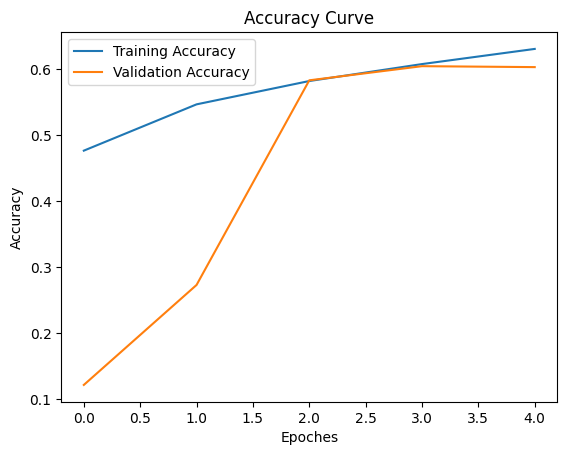

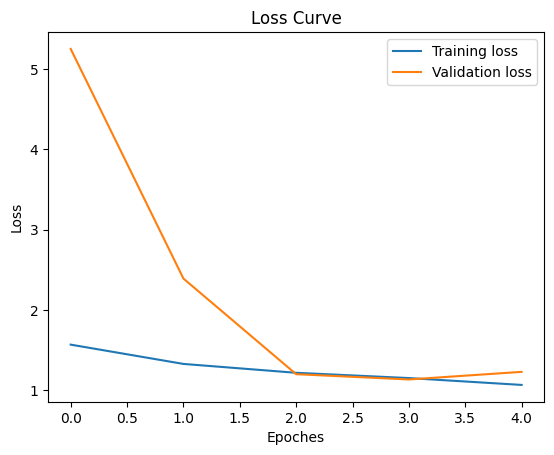

In [49]:
Plot_Training_Accuracy_Curves(history)
Plot_Training_Loss_Curves(history)

In [50]:
# --- Predictions on Test Set ---
y_score = model.predict(test)
y_pred = np.argmax(y_score, axis=1)


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step


In [51]:
# --- Extract True Labels ---
y_true_list = []
for images, labels in test:
    y_true_list.append(labels.numpy())

y_true = np.concatenate(y_true_list, axis=0)



--- Test Metrics ---
Accuracy = 0.5699404761904762
Precision = 0.5674039239655845
Recall = 0.5436978256389693
F1 Score = 0.543870424536802


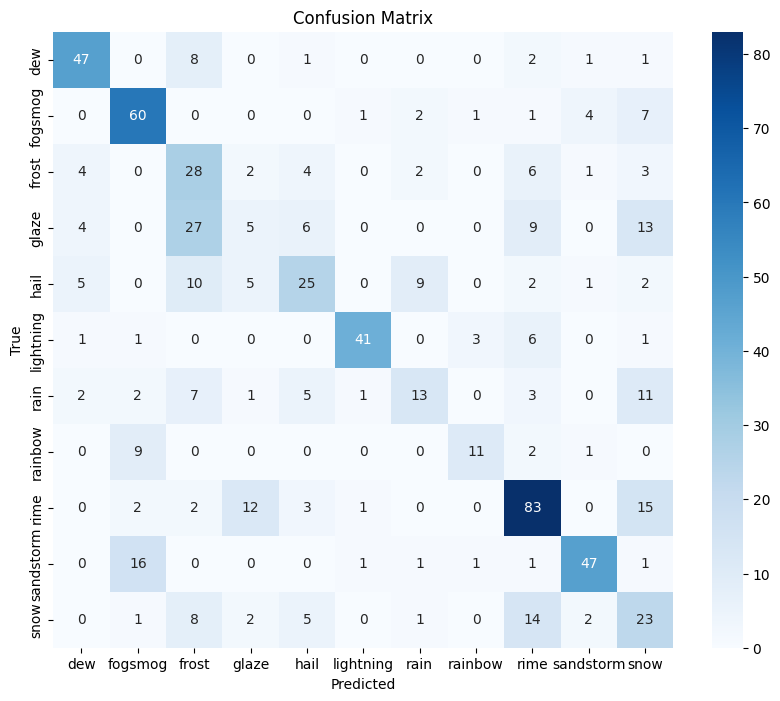

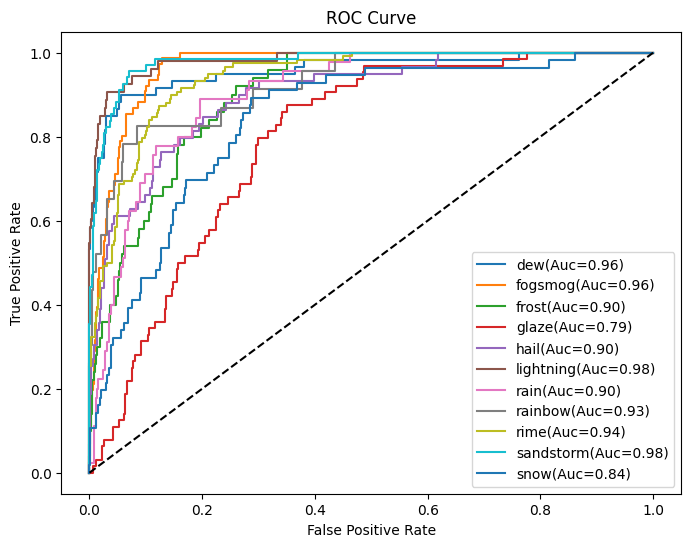

In [52]:
# --- Evaluate with Helper Functions ---

accuracy, precision, recall, f1 = Calculate_Confusion_Matrix(y_true, y_pred)

print("\n--- Test Metrics ---")
print("Accuracy =", accuracy)
print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


class_names = train_dataset.class_names

Plot_Confuision_Matrix(y_true, y_pred, class_names)
Plot_Roc_Auc_Curve(y_true, y_score, class_names)


inception V1

In [14]:
import os
import shutil
import random
from glob import glob
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

import json
import cv2
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score
)

from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, random_split

In [15]:
data_path = "big dataset"

In [16]:
def is_image_valid(path):
    try:
        with Image.open(path) as img:
            img.verify()  # will raise if file is broken
        return True
    except Exception:
        return False


def remove_corrupted_images(data_dir):
    removed = 0
    for cls in os.listdir(data_dir):
        cls_dir = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            path = os.path.join(cls_dir, fname)
            if not is_image_valid(path):
                os.remove(path)
                removed += 1
    print(f"Removed {removed} corrupted images")

In [17]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = .2,
    subset = 'training',
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
    )


Validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = .2,
    subset = 'validation',
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
    )

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [18]:
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
class_names = train_dataset.class_names

Batch shape: (32, 224, 224, 3)


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [20]:
DATA_DIR = "big dataset"
NUM_CLASSES = 11
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5 # عدد الإيبوكس في كل تشغيل
LR = 0.001


CHECKPOINT_PATH = 'inception_v1_checkpoint.pth'
BEST_MODEL_PATH = 'best_inception_v1.pth'


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cpu


In [21]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_tf)

TOTAL_SIZE = len(full_dataset)
train_size = int(0.7 * TOTAL_SIZE)
val_size = int(0.15 * TOTAL_SIZE)
test_size = TOTAL_SIZE - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    full_dataset, [train_size, val_size, test_size]
)

val_ds.dataset.transform = val_tf
test_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")

Train: 4803 | Val: 1029 | Test: 1030


In [23]:
from torchvision.models import GoogLeNet_Weights

weights = GoogLeNet_Weights.DEFAULT
model = models.googlenet(weights=weights)  # aux_logits=True تلقائي

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\maria/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:15<00:00, 3.40MB/s]


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

START_EPOCH = 0
best_val_loss = float('inf')

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    START_EPOCH = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming training from epoch {START_EPOCH}")

In [25]:
def train_epoch(model, loader):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def eval_epoch(model, loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

In [33]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

In [34]:
for epoch in range(START_EPOCH, START_EPOCH + EPOCHS):
    model.train()
    train_correct = 0
    train_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)

        # GoogLeNet returns tuple أثناء التدريب
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_ds)
    train_loss /= len(train_loader)

    model.eval()
    val_correct = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_ds)
    val_loss /= len(val_loader)

    # ✅ store values
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(
        f"Epoch {epoch+1} | "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f} | "
        f"Train Loss: {train_loss:.3f} | "
        f"Val Loss: {val_loss:.3f}"
    )

    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'best_val_loss': best_val_loss
    }, CHECKPOINT_PATH)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)


Epoch 1 | Train Acc: 0.832 | Val Acc: 0.863 | Train Loss: 0.503 | Val Loss: 0.429
Epoch 2 | Train Acc: 0.833 | Val Acc: 0.877 | Train Loss: 0.499 | Val Loss: 0.412
Epoch 3 | Train Acc: 0.843 | Val Acc: 0.861 | Train Loss: 0.464 | Val Loss: 0.421
Epoch 4 | Train Acc: 0.836 | Val Acc: 0.870 | Train Loss: 0.469 | Val Loss: 0.406
Epoch 5 | Train Acc: 0.845 | Val Acc: 0.861 | Train Loss: 0.459 | Val Loss: 0.410


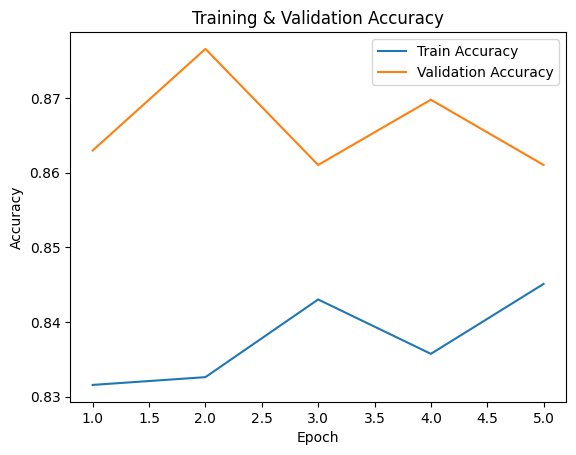

In [35]:
import matplotlib.pyplot as plt

epochs_range = range(START_EPOCH + 1, START_EPOCH + EPOCHS + 1)

plt.figure()
plt.plot(epochs_range, train_acc_list)
plt.plot(epochs_range, val_acc_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.show()

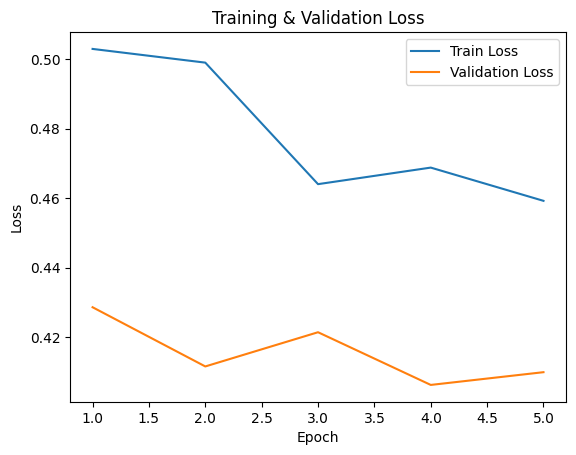

In [36]:
plt.figure()
plt.plot(epochs_range, train_loss_list)
plt.plot(epochs_range, val_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

In [37]:
test_loss, test_acc = eval_epoch(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8621


In [38]:
model.eval()
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [39]:
accuracy = np.mean(all_preds == all_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8621359223300971


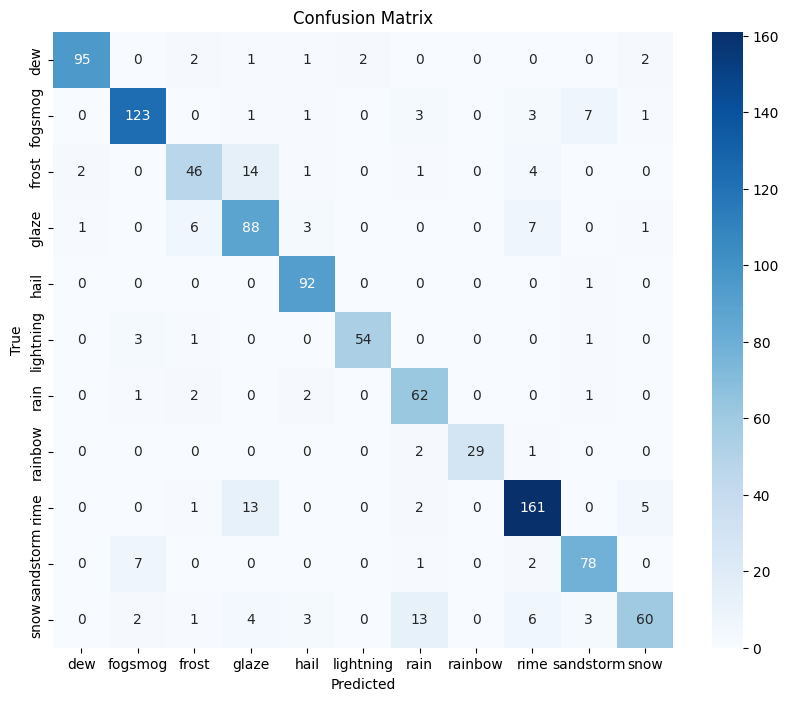

              precision    recall  f1-score   support

         dew       0.97      0.92      0.95       103
     fogsmog       0.90      0.88      0.89       139
       frost       0.78      0.68      0.72        68
       glaze       0.73      0.83      0.78       106
        hail       0.89      0.99      0.94        93
   lightning       0.96      0.92      0.94        59
        rain       0.74      0.91      0.82        68
     rainbow       1.00      0.91      0.95        32
        rime       0.88      0.88      0.88       182
   sandstorm       0.86      0.89      0.87        88
        snow       0.87      0.65      0.75        92

    accuracy                           0.86      1030
   macro avg       0.87      0.86      0.86      1030
weighted avg       0.87      0.86      0.86      1030



In [40]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

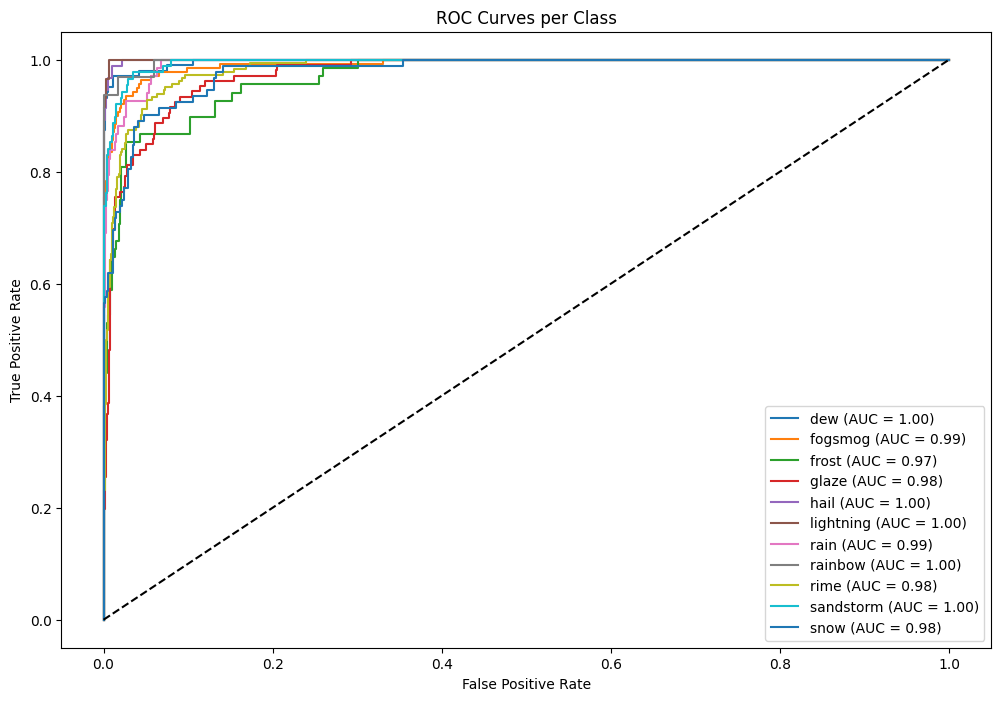

In [41]:
plt.figure(figsize=(12,8))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Class")
plt.legend()
plt.show()